Nama              : Dwi Abriansya Alimuddin

No Registrasi FGA : 0182180121-127

# Submission Time Series LSTM Dicoding

## Import Modul

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

## Upload dan Read Dataset

In [2]:
# Upload Dataset
from google.colab import files
uploaded = files.upload()

Saving AABA_2006-01-01_to_2018-01-01.csv to AABA_2006-01-01_to_2018-01-01.csv


In [3]:
# Read Dataset
df = pd.read_csv('AABA_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


## Data Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [5]:
# Missing Value
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

## Data Visualization

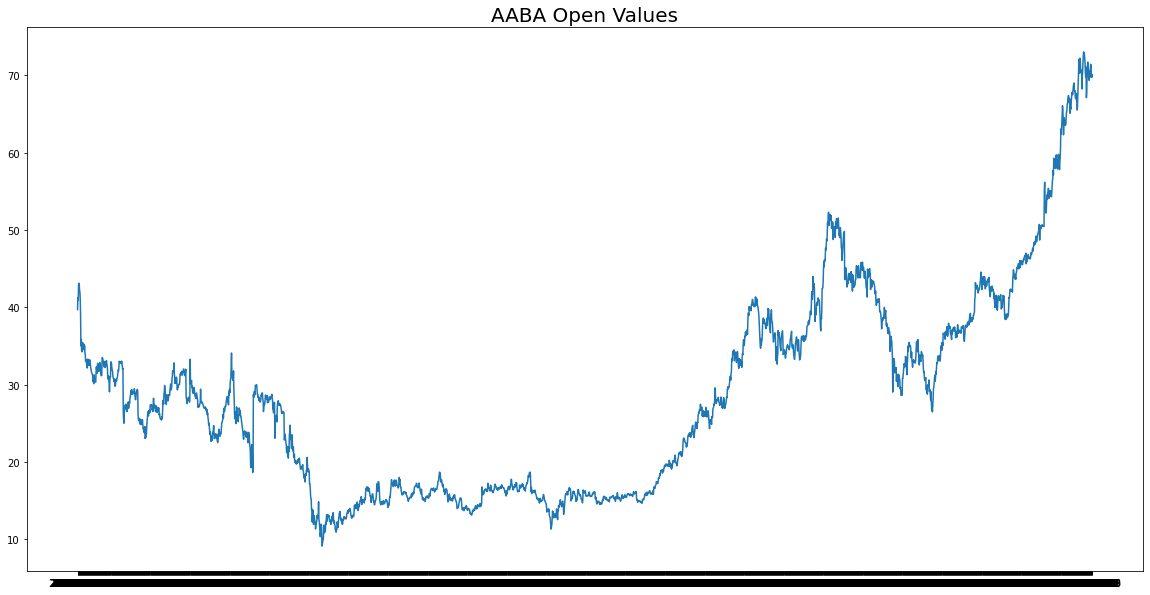

In [6]:
# Ekstrak data tanggal dan open
dates = df['Date'].values
open = df['Open'].values
 
# Plot data tanggal dan open
plt.figure(figsize=(20,10))
plt.plot(dates, open)
plt.title('AABA Open Values',
          fontsize=20);

## Train Test Split

### Split Data

In [7]:
# Split Data Train dan Test dengan Rasio 80:20, Shuffle=False agar split data tidak random
from sklearn.model_selection import train_test_split
date_latih, date_test, open_latih, open_test = train_test_split(dates, open, test_size=0.2, shuffle=False)

### Persiapan Train dan Test Set

In [8]:
# Inisiasi Fungsi windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# Memanggil fungsi windowed dataset
train_set = windowed_dataset(open_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(open_test, window_size=60, batch_size=100, shuffle_buffer=1000)

## Arsitektur Model

In [10]:
# Arsitektur Model
model = tf.keras.models.Sequential([
  # LSTM layer 1
  tf.keras.layers.LSTM(60, return_sequences=True),
  # LSTM layer 2
  tf.keras.layers.LSTM(60),
  # Hidden Layer 1
  tf.keras.layers.Dense(30, activation="relu"),
  # Hidden Layer 2
  tf.keras.layers.Dense(10, activation="relu"),
  # Output Layer
  tf.keras.layers.Dense(1),
])

## Threshold dan Callback

### Penentuan Threshold

In [11]:
# Skala Data
skala = np.max(df['Open'])-np.min(df['Open'])

# Threshold MAE
threshold = skala*0.1
threshold

6.3919999999999995

### Inisiasi Fungsi Callback

In [12]:
# Inisiasi fungsi callback dengan syarat akurasi 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<threshold) & (logs.get('val_mae')<threshold):
      print('\nMAE telah mencapai <10%!')
      self.model.stop_training = True

# Inisiasi class myCallback ke dalam variable callbacks
callbacks = myCallback()

## Compile dan Training Model

In [13]:
# Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

# Training Model
history = model.fit(
    train_set,                  # Data Train
    epochs=100,                 # Jumlah Epoch
    validation_data=test_set,   # Data Test
    callbacks=callbacks,        # Memanggil Fungsi Callback
    verbose=1)                  # Menampilkan Hasil Tiap Epoch

Epoch 1/100
24/24 [==============================] - 10s 45ms/step - loss: 23.7471 - mae: 24.2471 - val_loss: 45.4927 - val_mae: 45.9927
Epoch 2/100
24/24 [==============================] - 1s 20ms/step - loss: 23.4848 - mae: 23.9848 - val_loss: 45.2626 - val_mae: 45.7626
Epoch 3/100
24/24 [==============================] - 1s 18ms/step - loss: 23.2724 - mae: 23.7724 - val_loss: 45.0970 - val_mae: 45.5970
Epoch 4/100
24/24 [==============================] - 1s 17ms/step - loss: 23.0972 - mae: 23.5972 - val_loss: 44.9270 - val_mae: 45.4270
Epoch 5/100
24/24 [==============================] - 1s 17ms/step - loss: 22.9040 - mae: 23.4040 - val_loss: 44.7291 - val_mae: 45.2291
Epoch 6/100
24/24 [==============================] - 1s 17ms/step - loss: 22.6747 - mae: 23.1747 - val_loss: 44.4776 - val_mae: 44.9776
Epoch 7/100
24/24 [==============================] - 1s 17ms/step - loss: 22.3877 - mae: 22.8877 - val_loss: 44.1542 - val_mae: 44.6542
Epoch 8/100
24/24 [============================

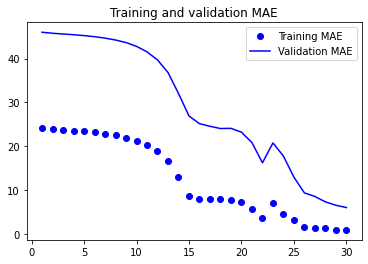

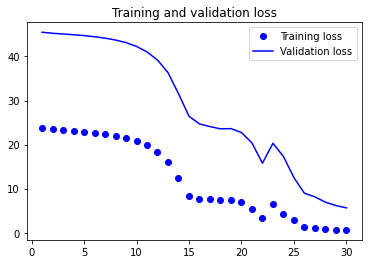

In [14]:
import matplotlib.pyplot as plt

# Ekstrak MAE dan loss dari training model
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# Plot MAE training dan validasi
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

# Plot loss training dan validasi
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()